In [1]:
from typing import Dict, List, Any
from pathlib import Path
import torch.nn as nn
import torch
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

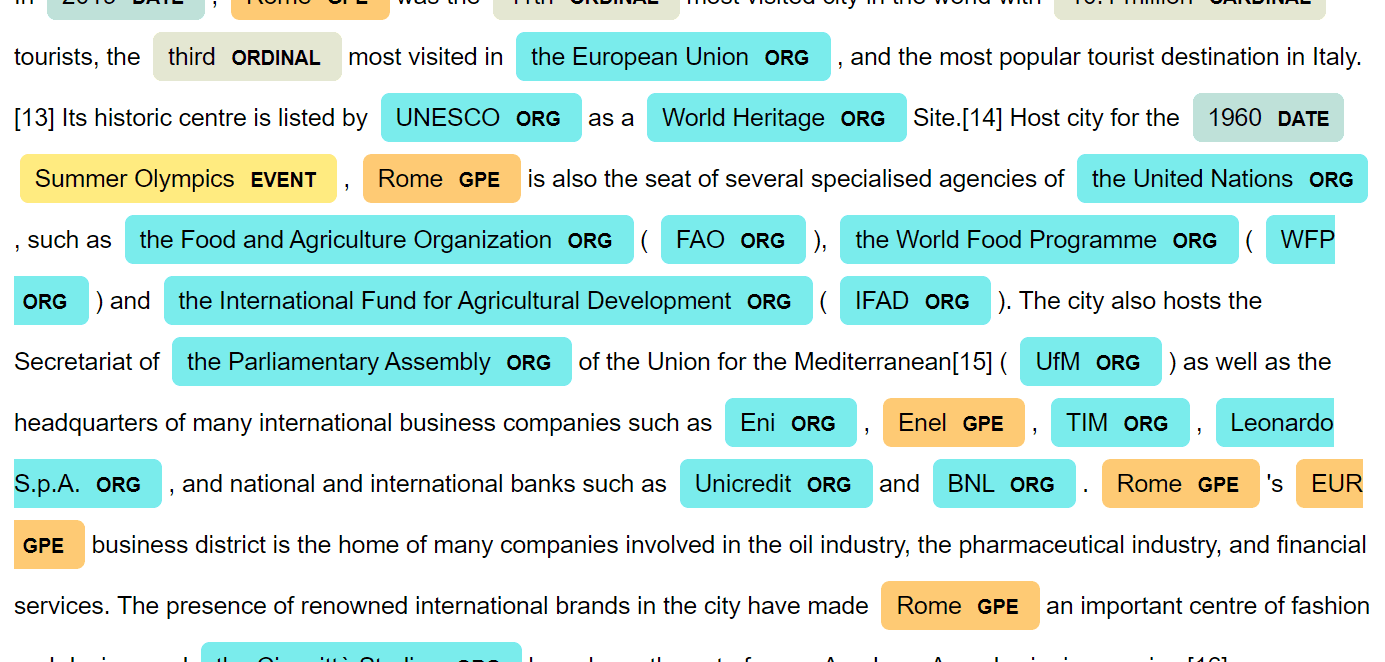

In [2]:
class Vocab:
    def __init__(self, token2idx: Dict[str, int], idx2token: List[str]):
        self.token2idx = token2idx
        self.idx2token = idx2token
    
    @staticmethod
    def from_data(data: List[str], pad: str = "[PAD]", unk: str = "[UNK]") -> 'Vocab':
        """ Get vocab from tokenized by spaces data """
        tok2idx = {pad: 0, unk: 1}
        idx2tok = [pad, unk]
        ...
        return Vocab(tok2idx, idx2tok)
    
    @property
    def pad(self):
        return self.idx2token[0]
    
    @property
    def pad_idx(self):
        return 0
    
    @property
    def unk(self):
        return self.idx2token[1]
    
    @property
    def unk_idx(self):
        return 1
    
    def __len__(self):
        ...
    
    def encode(self, sequence: List[str]) -> List[int]:
        return []

In [3]:
from dataclasses import dataclass

@dataclass(frozen=True)
class TaggedSentence:
    tokens: List[str]
    poses: List[str]
    ner: List[str]
    
    def __post_init__(self):
        assert len(self.tokens) == len(self.poses) == len(self.ner)

class TextPreprocessor:

    @staticmethod
    def preprocess(path: Path) -> List[TaggedSentence]:
        data: List[TaggedSentence] = []
        with open(path) as f:
            lines = f.readlines()
            sentence: List[str] = []
            for line in lines:
                # YOUR CODE HERE
                # здесь следует обратить внимание на перевод строки: здесь заканчивается текущее предложение :)
                pass
        return data
    

In [4]:
data = TextPreprocessor.preprocess("eng.train")
valid_data = TextPreprocessor.preprocess("eng.testa")

In [5]:
data[:2]

[TaggedSentence(tokens=['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], poses=['NNP', 'VBZ', 'JJ', 'NN', 'TO', 'VB', 'JJ', 'NN', '.'], ner=['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O']),
 TaggedSentence(tokens=['Peter', 'Blackburn'], poses=['NNP', 'NNP'], ner=['I-PER', 'I-PER'])]

In [6]:
token_vocab = Vocab.from_data([" ".join([t for t in d.tokens]) for d in data])
pos_vocab = Vocab.from_data([" ".join([t for t in d.poses]) for d in data])
ner_vocab = Vocab.from_data([" ".join([t for t in d.ner]) for d in data])

In [7]:
from torch.utils.data import Dataset
import torch
class CustomTagDataset(Dataset):
    def __init__(self, data: List[TaggedSentence], tok_vocab: Vocab, ner_vocab: Vocab, pos_vocab: Vocab):
        self._data = data
        self._tok = tok_vocab
        self._ner = ner_vocab
        self._pos = pos_vocab
    
    def __getitem__(self, idx: int):  
        # YOUR CODE HERE
        return {"sent": enc_sent,
                "pos": enc_pos,
                "ner": enc_ner,
               }
    
    def __len__(self):
        return len(self._data)

In [8]:
from torch.nn.utils.rnn import pad_sequence
def collate_fn_padd(batch):
    return {
        "sent": pad_sequence([s["sent"] for s in batch], padding_value=0, batch_first=True),
        "pos": pad_sequence([s["pos"] for s in batch], padding_value=0, batch_first=True),
        "ner": pad_sequence([s["ner"] for s in batch], padding_value=0, batch_first=True),
    }

In [9]:
from torch import Tensor
class NERTagger(nn.Module):
    def __init__(self, token_vocab: Vocab, 
                 ner_vocab: Vocab, 
                 emb_dim: int, hidden_dim: int):
        super(NERTagger, self).__init__()
        self.emb = ...
        self.lstm = ... # add BiLSTM layer
        self.lin = ...
    
    def forward(self, batch: Tensor) -> Tensor:
        # TODO
        return self.lin(feats)

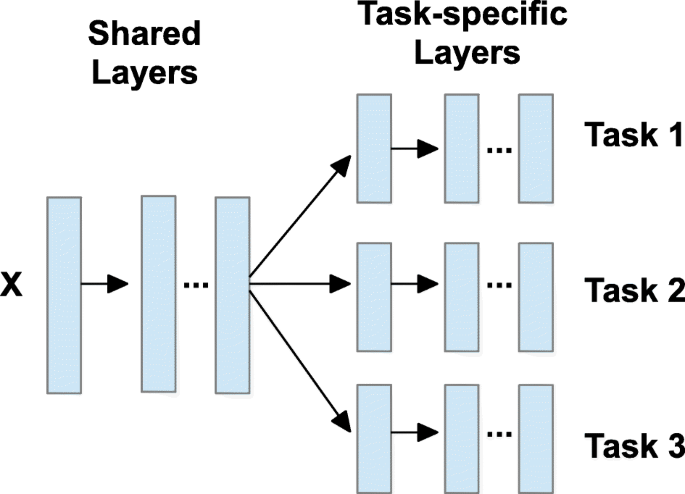

In [82]:
from torch import Tensor
class MultiTaskTagger(nn.Module):
    def __init__(self, token_vocab: Vocab, tag_vocab: Vocab, emb_dim: int, hidden_dim: int):
        super(MultiTaskTagger, self).__init__()
        # TODO
    
    def forward(self, batch: Tensor) -> Tuple[Tensor, ...]:
        # TODO

SyntaxError: unexpected EOF while parsing (<ipython-input-82-16deeb09ff06>, line 8)

In [10]:
from torch.utils.data import DataLoader
data_train = DataLoader(CustomTagDataset(data, token_vocab, ner_vocab, pos_vocab), batch_size=16, shuffle=True, collate_fn=collate_fn_padd)
data_valid = DataLoader(CustomTagDataset(valid_data, token_vocab, ner_vocab, pos_vocab), batch_size=16, shuffle=False, collate_fn=collate_fn_padd)

In [11]:
import tqdm

BATCH_SIZE = 16
EPOCHS = 5
DEVICE = torch.device('cpu')

In [12]:
from sklearn.metrics import classification_report
@torch.no_grad()
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    model.eval()
    all_ = 0
    correct = 0
    for batch in data:
        # YOUR CODE HERE
    print(correct / all_)

In [13]:
def train(model: nn.Module,
          train_data: List[Any], 
          val_data: List[Any] = None, 
          epochs: int = 5, 
          batch_size: int = 16):
    
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=0)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    if val_data is not None:
        print_metrics(model, val_data, max_len=128)
    
    for epoch in range(EPOCHS):
        print(f"epoch: {epoch}")
        model.train()
        for i, batch in tqdm.notebook.tqdm(enumerate(train_data)):
            pred = model(batch['sent'])
            loss = criterion(pred.permute(0,2,1), batch["ner"])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print_metrics(model, val_data, max_len=128)

In [14]:
model = NERTagger(token_vocab, ner_vocab, emb_dim=100, hidden_dim=128)
train(model, data_train, val_data=data_valid)

tensor(0.0420)
epoch: 0


0it [00:00, ?it/s]

tensor(0.8980)
epoch: 1


0it [00:00, ?it/s]

tensor(0.9143)
epoch: 2


0it [00:00, ?it/s]

tensor(0.9089)
epoch: 3


0it [00:00, ?it/s]

tensor(0.9183)
epoch: 4


0it [00:00, ?it/s]

tensor(0.9175)


In [15]:
test_data = TextPreprocessor.preprocess("eng.testb")

In [17]:
test_data[0]

TaggedSentence(tokens=['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'CHINA', 'IN', 'SURPRISE', 'DEFEAT', '.'], poses=['NN', ':', 'NNP', 'VB', 'NNP', 'NNP', ',', 'NNP', 'IN', 'DT', 'NN', '.'], ner=['O', 'O', 'I-LOC', 'O', 'O', 'O', 'O', 'I-PER', 'O', 'O', 'O', 'O'])

In [18]:
data_test = DataLoader(CustomTagDataset(test_data, token_vocab, ner_vocab, pos_vocab), batch_size=16, shuffle=False, collate_fn=collate_fn_padd)

In [34]:
print_metrics(model, data_test, max_len=128)

tensor(0.8790)
